In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from stochax import OrnsteinUhlenbeck, CoxIngersollRoss
from itertools import product

### Utilities and parameters

In [2]:
def show_realizations(realizations: pd.DataFrame):
    """Show process realizations"""

    m = realizations.mean(axis=1)
    s = realizations.std(axis=1)
    
    fig, ax = plt.subplots(1, 1)
    
    ax.plot(realizations, color='gray', alpha=0.1)
    ax.plot(m, color='blue')
    ax.plot(m+s, color='blue', linewidth=0.75)
    ax.plot(m-s, color='blue', linewidth=0.75)
    
    fig.tight_layout()
    fig.show()


def get_calibrations(realizations: pd.DataFrame) -> pd.DataFrame:
    """Compute calibration using MLE or Parametric-Bootstrap"""

    calibrations = list()
    
    methods = ('mle', 'parametric_bootstrap')
    # iterate over all possible model realization and calibration method
    grid = product(methods, realizations.columns)
    
    for method, col in tqdm(grid):
        x = realizations[col]
        try:
            res = process.calibrate(
                x,
                delta=delta,
                method=method
            )
        
            calibrations.append({'method': method, **process.parameters})
        except:
            pass
    
    return pd.DataFrame(calibrations)
    
    

def rmse(x) -> float:
    """Compute Root Mean Square Error"""
    v = x.dropna().values
    return np.sqrt(np.mean(v**2))

def show_distribution(calibrations: pd.DataFrame, true: dict):
    """Show calibration results"""
    fig, axes = plt.subplots(len(true), 1, figsize=(10, 8))

    for ax, (key, val) in zip(axes, true.items()):
        sns.histplot(calibrations, x=key, hue='method', bins=25, alpha=0.25, ax=ax, kde=True)
        ax.axvline(val, linestyle='dashed', color='black')
    
    fig.tight_layout()
    fig.show()

def compute_errors(calibrations: pd.DataFrame, true: dict) -> pd.DataFrame:
    """Compute RMSE and aggregate results"""

    map_agg = dict()
    for key, val in true.items():
        col = f'delta_{key}'
        calibrations[col] = calibrations[key] - val

        map_agg[f'rmse_{key}'] = (col, rmse)
        
    return calibrations.groupby('method').agg(**map_agg)


true_parameters = dict(
    kappa = 0.25,
    alpha=1.,
    sigma=0.5,
)
n_steps = 250
delta = 1/n_steps
initial_value = 0.2
n_samples = 250

## Ornstein-Uhlenbeck

In [3]:
process = OrnsteinUhlenbeck(**true_parameters)

realizations = process.simulate(
    initial_value=initial_value,
    delta=delta,
    n_simulations=n_samples,
    n_steps=n_steps
)

/tmp/ipykernel_55409/2949430220.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


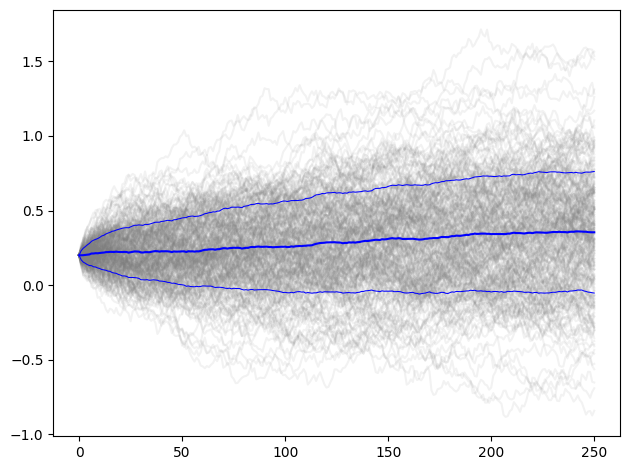

In [4]:
show_realizations(realizations)

In [5]:
calibrations = get_calibrations(realizations)

500it [04:19,  1.93it/s]  


/tmp/ipykernel_55409/2949430220.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


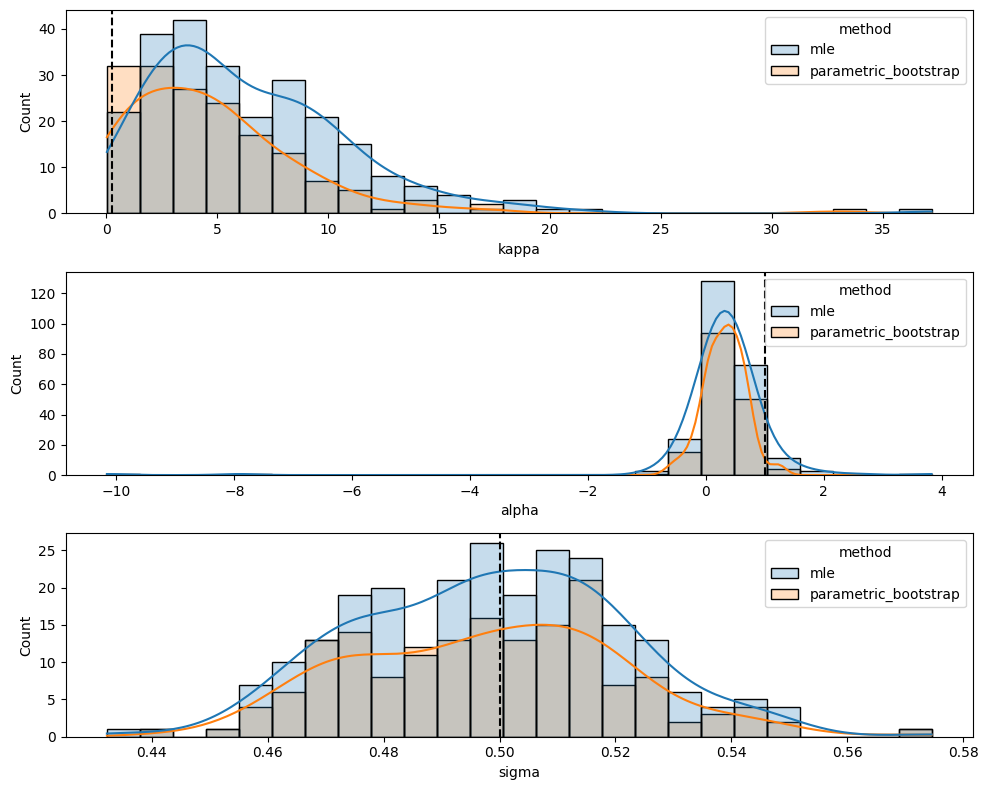

In [6]:
show_distribution(calibrations, true_parameters)

In [7]:
compute_errors(calibrations, true_parameters)

,rmse_kappa,rmse_alpha,rmse_sigma
method,,,
mle,7.708075,1.215345,0.022776
parametric_bootstrap,6.097326,0.767300,0.022841


## Cox-Ingersoll-Ross

In [8]:
process = CoxIngersollRoss(**true_parameters)

realizations = process.simulate(
    initial_value=initial_value,
    delta=delta,
    n_simulations=n_samples,
    n_steps=n_steps
)

/tmp/ipykernel_55409/2949430220.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


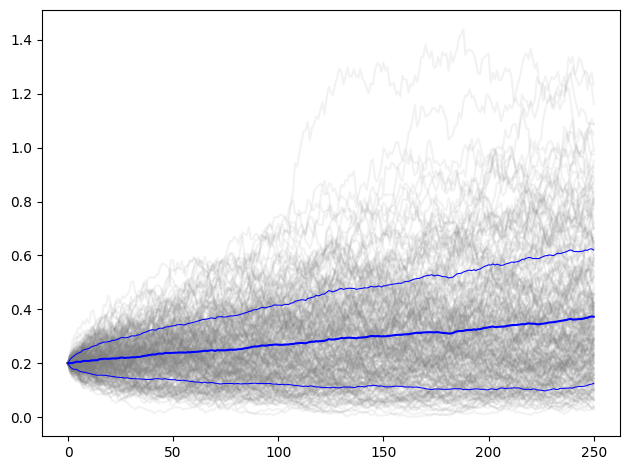

In [9]:
show_realizations(realizations)

In [10]:
calibrations = get_calibrations(realizations)

500it [03:58,  2.09it/s]  


/tmp/ipykernel_55409/2949430220.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


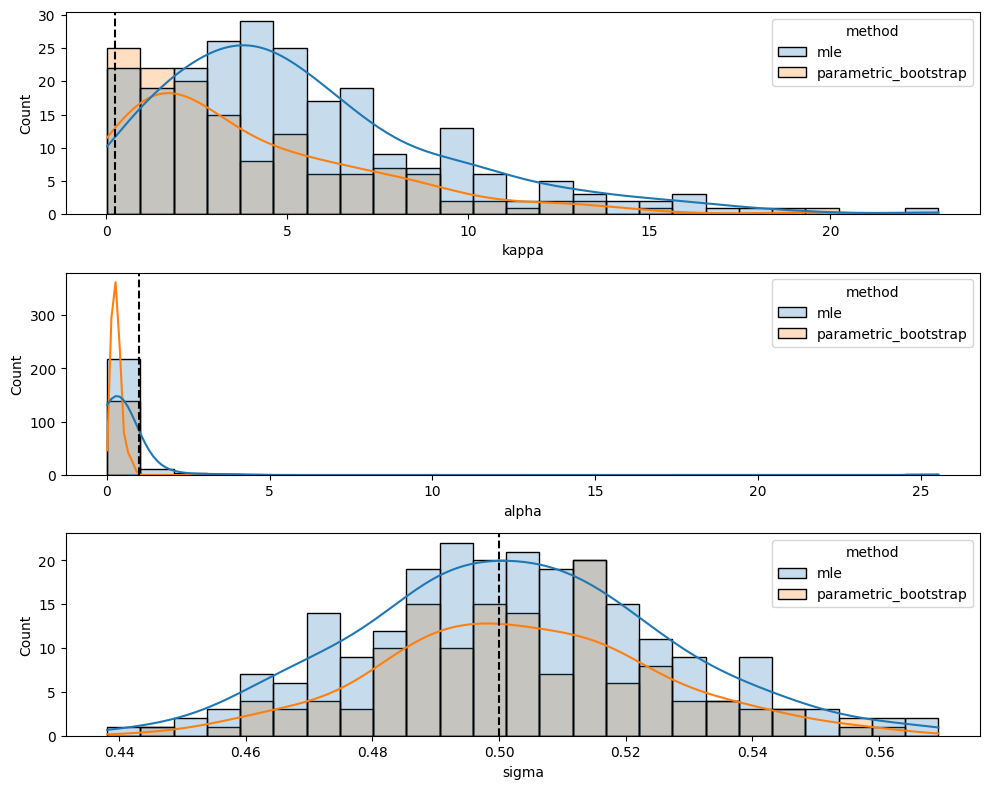

In [11]:
show_distribution(calibrations, true_parameters)

In [12]:
compute_errors(calibrations, true_parameters)

,rmse_kappa,rmse_alpha,rmse_sigma
method,,,
mle,6.567243,1.771853,0.024006
parametric_bootstrap,5.211235,0.718074,0.021734
